In [2]:
import logging, sys
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display, Latex

from pynamics import downsample, downsample_split, avg_over
from pynamics.utils import np_cache, eigsort
from pynamics.systems import DoubleWell
from randnn.plotting import *
from pytransfer.transfer_operator import *

rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)
np.set_printoptions(threshold=100)

ModuleNotFoundError: No module named 'nptyping'

# Applying the transfer operator approach

### 1. Coarse-graining in space:

#### Clustering

We run an explicit coarse-graining step by clustering the embedding space.

### 2. Coarse-graining in time: 

#### Downsampling
We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory, discarding many intermediate timesteps.

#### Delay embedding
To achieve a near-memory-less (Markovian) definition of state, we stack delayed copies of measurements within a short time window.

# Parameters

In [3]:
# ------------------------
# DOUBLE WELL PARAMETERS
# ------------------------

# Main parameters:
BETA = 1

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.01 # 0.01 
DOWNSAMPLE_RATE = 10 # 10

TIMESPAN = 10000 # 100000
N_STEPS = int(TIMESPAN // TIMESTEP)
N_BURNIN_STEPS = 1000 

N_CLUSTERS = 500
TRANSITION_TIMESCALE = 100 # This is the number of timesteps to take before counting a transition from one cell to the next
# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

In [4]:
RATE = 1
TIMESTEP = 0.01
BETAS = [0.05, 0.1, 0.5, 1, 2, 3, 5, 8]
TIMESTEP = 0.01
N_STEPS = 1000000
plot_entropies_with_betas(BETAS, RATE, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS, labeling_method="kmeans", is_overdamped=False)

NameError: name 'plot_entropies_with_betas' is not defined

# Generating data

In [ ]:
double_well = DoubleWell(beta=BETA, timestep=TIMESTEP, is_overdamped=False)
time_series = double_well.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE, k=50)

## Equilibrium

Let's establish that we've actually settled into equilibrium. 

### Boltzmann distribution

The first check is that the Boltzmann distributions appear qualitatively similar. If this is off, we already know we need to go back to the drawing board.


In [ ]:
N_BINS = 50

dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T

# We compare the Boltzmann distribution directly from data...

plt.hist2d(time_series[:, 0], time_series[:, 1], bins=N_BINS*2)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Boltzmann distribution from data directly")
plt.show()

# ...with the distribution from the transfer matrix...

cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

stable_dist = np.abs(eigvecs[:,0])/ np.sum(np.abs(eigvecs[:, 0]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 0], cluster_centers[:, 1], bins=N_BINS//3, weights=stable_dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Stationary distribution of the (transpose) transfer matrix.")
plt.show()

# ... and against the theoretical distribution

weights = double_well.boltzmann_weights(cluster_centers)

plt.hist2d(cluster_centers[:, 0], cluster_centers[:, 1], bins=N_BINS**2, weights=weights, range=[[-2, 2], [-4, 4]])
plt.xlabel("x")
plt.ylabel("v")
plt.title("True Boltzmann distribution.")
plt.show()

In [ ]:
cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

dist = np.abs(eigvecs[:,1])/ np.sum(np.abs(eigvecs[:, 1]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 0], cluster_centers[:, 1], bins=N_BINS//3, weights=dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("2nd eigenvector of the (transpose) transfer matrix.")
plt.show()

cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

dist = np.abs(eigvecs[:,2])/ np.sum(np.abs(eigvecs[:, 2]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 0], cluster_centers[:, 1], bins=N_BINS//3, weights=dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("3rd eigenvector of the (transpose) transfer matrix.")
plt.show()


### Energy distribution

For a more quantitative check, we can compare the observed energy distribution to the theoretical distribution and confirm that the equipartition theorem holds (i.e. that each dof has, on average, an energy $kT/2$). 

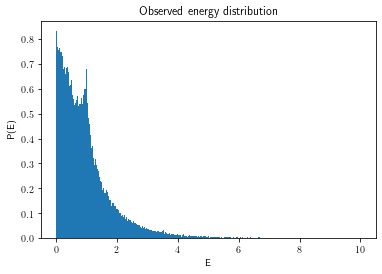

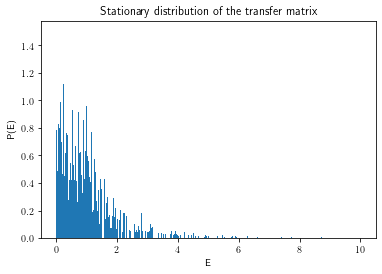

1.0


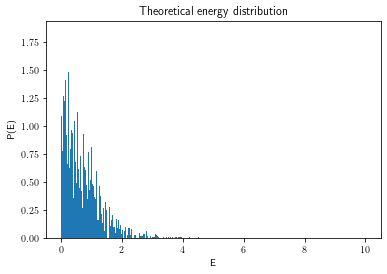

The average energy of the particle from the time series is 0.9658320100251299
The average energy of the particle from the transfer operator is 0.955258459104399
The theoretical energy of the particle is (check) 0.6772339541018171
The theoretical energy is (as given by the equipartition theorem):


<IPython.core.display.Latex object>

In [5]:
# We compare the energy distribution observed directly in data...
ts_energies = double_well.energy(time_series) 
plt.title("Observed energy distribution")
plt.hist(ts_energies, density=True, bins=N_CLUSTERS, range=[0, 10])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

ts_avg_energy = np.mean(ts_energies)

# ...with the distribution from the transfer matrix...
tm_energies = double_well.energy(cluster_centers)
plt.title("Stationary distribution of the transfer matrix")
plt.hist(tm_energies, density=True, bins=N_CLUSTERS, weights=stable_dist, range=[0, 10])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

print(np.sum(stable_dist))
tm_avg_energy = np.mean(stable_dist @ tm_energies)

# ...and against the theoretical distribution.
probs = double_well.boltzmann_probs(cluster_centers)

theoretical_energies = double_well.energy(cluster_centers) 
plt.title("Theoretical energy distribution")
plt.hist(theoretical_energies, density=True, bins=N_CLUSTERS, weights=weights, range=[0, 10])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

theoretical_avg_energy = np.mean(probs @ tm_energies)

# And compare the average energy.
print(f"The average energy of the particle from the time series is {ts_avg_energy}")
print(f"The average energy of the particle from the transfer operator is {tm_avg_energy}")
print(f"The theoretical energy of the particle is (check) {theoretical_avg_energy}")

print("The theoretical energy is (as given by the equipartition theorem):")
display(Latex(f"$2\cdot kT/2 = {1./(BETA)}$ (there are 2 dofs)"))

### Convergence

We make sure we've included enough burn in samples and that the running average energy isn't fluctuating too wildly.

Calculating running average: 100%|██████████| 95/95 [00:02<00:00, 32.54it/s]


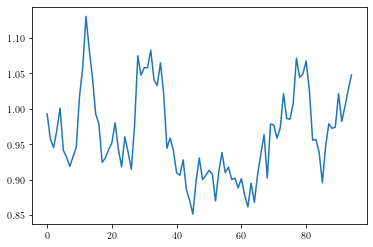

In [6]:
running_avg_energy = double_well.running_avg(
    time_series, 
    double_well.energy,
    window_size=5000,
    step_size=1000,
    verbose=True
)

plt.plot(running_avg_energy)


### Eigenvalue spectrum & Timescale separation

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


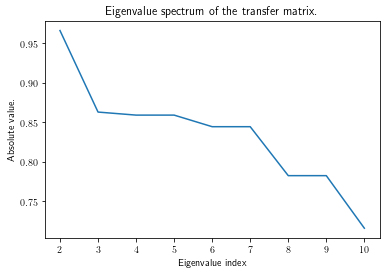

In [7]:
plot_eig_spectrum(eigvals, EIGENVALUE_RANGE, "Eigenvalue spectrum of the transfer matrix.")

In [11]:
betas =[0.05,0.1,0.5, 1, 2, 3, 5, 8]
measured_energies = np.zeros(len(betas))
matrix_energies = np.zeros(len(betas))

TIMESTEP = 0.01
N_STEPS = 100000
for i, beta in enumerate(betas):
    dw = DoubleWell(beta=beta, timestep=TIMESTEP, is_overdamped=False)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    
    print(traj.shape)
    cluster_centers = matrix.cluster_centers
    cluster_energies = dw.energy(cluster_centers)
    stable_dist = np.abs(matrix.eigvecs[:,0])/ np.sum(np.abs(matrix.eigvecs[:, 0]))
    
    measured_energies[i] = np.mean(dw.energy(traj))
    matrix_energies[i] = np.mean(stable_dist @ cluster_energies)
 
betas = np.array(betas)

plt.title("$\langle E \\rangle$ with $\\beta$ ($\\tau=1$)")
plt.yscale('log')
plt.xscale('log')

plt.plot(betas, 1./betas, label="From equipartition theory")
plt.plot(betas, measured_energies, label="Directly from data")
plt.plot(betas, matrix_energies, label="Transfer matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("$\langle E \\rangle$")
plt.show()

plt.title("Error in $\langle E \\rangle$ with $\\beta$ ($\\tau=1$)")
traj_errors = np.abs(measured_energies - 1./beta)*beta * 100
matrix_errors = np.abs(matrix_energies - 1./beta)*beta * 100

plt.plot(betas[3:], traj_errors[3:], label="From data")
plt.plot(betas[3:], matrix_errors[3:], label="Transfer matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("Relative error (\%)") 
plt.show()

INFO:root:Loading from save ./saves/trajectories/trajectory-c36ec56b34783cd0d2c3ded41bad75ab.npy
INFO:root:Loading from save ./saves/trajectories/trajectory-271426c7213622423b3d05cdcc49c85b.npy


(100000, 2)


INFO:root:Loading from save ./saves/trajectories/trajectory-d92b9a3e18f9da949a9573d92288cf69.npy


(100000, 2)


INFO:root:Loading from save ./saves/trajectories/trajectory-d603a59bfcc6a11b9f988ce373d9a835.npy


(100000, 2)


KeyboardInterrupt: 

In [9]:
print("FROM KRAMER'S RATE THEORY")
print("\n\tSTARTING AT X=0")
print(f"\tFirst Passage Time (-inf to 0) {double_well.first_passage_time(-1)}")

print('\n\tAVG OVER THE IVL')
print(f"\tFirst Passage Time (-inf to 0) {double_well.avg_first_passage_time()}")

print("\nFROM TRAJECTORIES DIRECTLY")
print(f"First Passage Time (-inf to 0) {double_well.measure_first_passage_time(time_series[:, 0])* DOWNSAMPLE_RATE}")

print("\nFROM TRANSFER MATRIX")
#print(f"Max eigval {eigvals[1]} and inverse {1./eigvals[1]}")
print(f"Max timescale {double_well.get_timescale(eigvals[1], multiplier=DOWNSAMPLE_RATE)}")

#transition_times= np.zeros(1000)

#for i in range(1, 1001):
#    transition_times[i-1] = double_well.transition_time(time_series, i)

#plt.plot(transition_times)

FROM KRAMER'S RATE THEORY

	STARTING AT X=0
	First Passage Time (-inf to 0) 1.4358592670088093

	AVG OVER THE IVL
	First Passage Time (-inf to 0) 1.222805493058904

FROM TRAJECTORIES DIRECTLY
First Passage Time (-inf to 0) 13.440860215053762

FROM TRANSFER MATRIX
Max timescale 2.9076941517886197


/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/systems/double_well.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  return -float(self.timestep * multiplier/ np.log(eigval))


In [12]:
# Vary temperature, fix transition_rate = 1

betas =[0.05,0.1,0.5, 1, 2, 3, 5]
TIMESTEP = 0.01
N_STEPS = 1000000

theoretical_times = np.zeros(len(betas))
trajectory_times =  np.zeros(len(betas))
matrix_times =  np.zeros(len(betas))
for i, beta in enumerate(betas):
    dw = DoubleWell(beta=beta, timestep=TIMESTEP, is_overdamped=False)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    theoretical_times[i] = dw.avg_first_passage_time()
    trajectory_times[i]=dw.measure_first_passage_time(traj[:,0])
    matrix_times[i]=dw.get_timescale(matrix.eigvals[1])
    #print(f"First Passage Time\t(-inf to 0) {theoretical_times[i]}")
    #print(f"Trajectory Passage Time\t(-inf to 0) {trajectory_times[i]}")
    # print(f"Max timescale\t\t{matrix_times[i]}")

plt.title("Timescale scaling with $\\beta$ ($\\tau=1$)")
plt.yscale('log')
plt.plot(betas, theoretical_times, label="Kramers")
plt.plot(betas, trajectory_times, label="Directly from data")
plt.plot(betas, matrix_times, label="Transfer Matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("$t_{imp}$")
plt.show()

plt.title("Error with $\\beta$ ($\\tau=1$)")
traj_errors = np.abs(trajectory_times - theoretical_times)/theoretical_times * 100
matrix_errors = np.abs(matrix_times - theoretical_times)/theoretical_times * 100

plt.plot(betas[1:], traj_errors[1:], label="From data")
plt.plot(betas[1:], matrix_errors[1:], label="Transfer matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("Relative error (\%)") 
plt.show()



INFO:root:Loading from save ./saves/trajectories/trajectory-7d34553b20579cd355d7579d05a24619.npy


KeyboardInterrupt: 

Generating samples: 100%|██████████| 10000/10000 [00:00<00:00, 30400.12it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-145d46b13ae3c019a05e2b2dbc581331.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
INFO:root:Loading from save ./saves/trajectories/trajectory-145d46b13ae3c019a05e2b2dbc581331.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualen

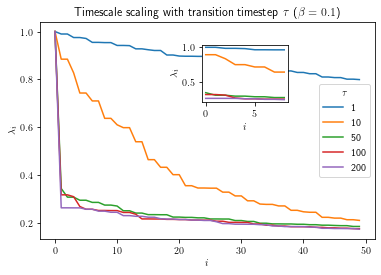

In [15]:
# High temperature, vary transition rate

RATES = [1, 10, 50, 100, 200]
BETA = 0.1
TIMESTEP = 0.01
N_STEPS = 10000
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS, False, "kmeans")

Generating samples: 100%|██████████| 10000/10000 [00:00<00:00, 18890.56it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-a5376efd707220769e6c7482b301e9f5.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
INFO:root:Loading from save ./saves/trajectories/trajectory-a5376efd707220769e6c7482b301e9f5.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualen

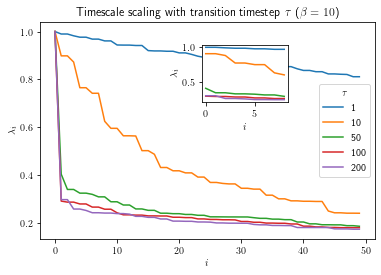

In [16]:
# Low temperature, vary transition rate

RATES = [1, 10, 50, 100, 200]
BETA = 10
TIMESTEP = 0.01
N_STEPS = 10000
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS, False, "kmeans")

INFO:root:Loading from save ./saves/trajectories/trajectory-c36ec56b34783cd0d2c3ded41bad75ab.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
INFO:root:Loading from save ./saves/trajectories/trajectory-271426c7213622423b3d05cdcc49c85b.npy
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py

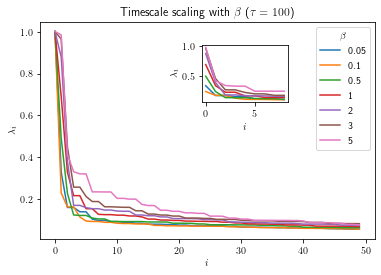

In [20]:
# Low temperature, vary transition rate
BETAS =[0.05,0.1,0.5, 1, 2, 3, 5]
TIMESTEP = 0.01
N_STEPS = 100000
plot_eigval_spectra_with_betas(BETAS, TRANSITION_TIMESCALE, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS, False, "kmeans")

### Timescale convergence

In [ ]:
N_CLUSTERS_LIST = [9, 100, 400]
TRANSITION_TIMES = range(1, 20, 4)

plot_t_imp_scaling(time_series, 
                   1, 
                   n_clusters_list=N_CLUSTERS_LIST, 
                   transition_times=TRANSITION_TIMES,
                   timestep=TIMESTEP/DOWNSAMPLE_RATE)